# Adversarial Examples for MNIST

In [1]:
import torch
import torchvision
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from cnn import CNN
from dataloader_utils import make_mnist_dataloaders
from data_utils import inputs_with_outputs

BATCH_SIZE = 4
NUM_WORKERS = 1
DATA_DIR = '/tmp/mnist_data/'
NUM_CHAN = 1
NUM_CLASS = 10
CLASSIFIER_MODEL_FILE = '/home/dylan/trained_model_files/pytorch/glados/glados_classifier/glados_classifier_net.pt'

# intialize MNIST dataloaders
train_loader, test_loader = make_mnist_dataloaders(
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    data_dir=DATA_DIR
)

# initialize classifier
classifier = CNN(
    in_chan=NUM_CHAN,
    out_dim=NUM_CLASS,
    out_act=None
)

# load trained cnn classifier paremeters
classifier.load_state_dict(torch.load(CLASSIFIER_MODEL_FILE, map_location=torch.device('cpu')))

<All keys matched successfully>

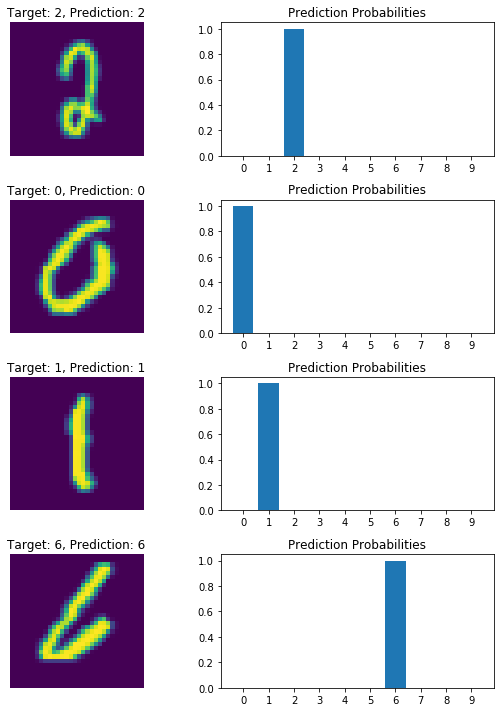

In [2]:
# get a batch from the test loader
test_batch = iter(test_loader).next()
test_samples, test_labels = test_batch[0], test_batch[1]

# require gradient for input data (need to do this to compute the gradients for inputs dutring backward() call)
test_samples.requires_grad = True

# get predictions
outputs = classifier(test_samples)
pred_prob = torch.nn.functional.softmax(outputs, dim=-1)
pred = torch.argmax(pred_prob, dim=-1)

# convert samples, labels, and prediction probabilities to numpy arrays
samples_np = np.transpose(test_samples.detach().numpy(), [0, 2, 3, 1])
labels_np = test_labels.detach().numpy()
pred_prob_np = pred_prob.detach().numpy()
pred_np = pred.detach().numpy()

fig = inputs_with_outputs(samples_np, labels_np, pred_prob_np, pred_np, figsize=(8, 10))

In [3]:
# initialize a cross entropy loss function
loss_fn = torch.nn.CrossEntropyLoss()

# compute loss on current test batch
loss = loss_fn(outputs, test_labels)

# compute gradients of loss on backward pass
loss.backward()

# get gradients of input data
grads = test_samples.grad

# get sign of gradients
signed_grads = torch.sign(grads)

# perturn test samples using FGSM
adv_test_samples = test_samples + ((0.2) * signed_grads)

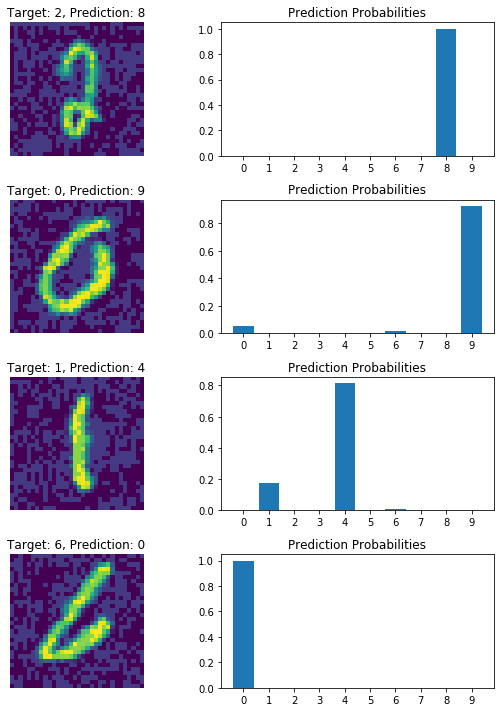

In [4]:
# get predictions on adversarial examples
adv_outputs = classifier(adv_test_samples)
adv_pred_prob = torch.nn.functional.softmax(adv_outputs, dim=-1)
adv_pred = torch.argmax(adv_pred_prob, dim=-1)

# convert samples, labels, and prediction probabilities to numpy arrays
adv_samples_np = np.transpose(adv_test_samples.detach().numpy(), [0, 2, 3, 1])
adv_labels_np = test_labels.detach().numpy()
adv_pred_prob_np = adv_pred_prob.detach().numpy()
adv_pred_np = adv_pred.detach().numpy()

adv_fig = inputs_with_outputs(adv_samples_np, adv_labels_np, adv_pred_prob_np, adv_pred_np, figsize=(8, 10))